In [5]:
import sys
import os
import math
import numpy as np
import torch
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("deep_feature_reweighting"), '../..')))
from external.wdpruning.vit_wdpruning import VisionTransformerWithWDPruning
import matplotlib.pyplot as plt

In [2]:
ckpt = torch.load("F:/model_stuff/r90e20 wb/checkpoint-best.pth", map_location=torch.device('cpu'))['model']

C:\Users\elmop\AppData\Local\Temp\ipykernel_18304\3087101899.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("F:/model_stuff/r90e20 wb/checkpoint-best.

In [3]:
model = VisionTransformerWithWDPruning(num_classes=2,
                                       patch_size=16, embed_dim=768,
                                       depth=12, num_heads=12, mlp_ratio=4,
                                       head_pruning=True, fc_pruning=True)

using stride: 16, and patch number is num_y14 * num_x14
using drop_out rate is : 0.0
using attn_drop_out rate is : 0.0
using drop_path rate is : 0.1


In [9]:
model.load_state_dict(ckpt, strict=False)

ratios = np.zeros((12,4), dtype=np.float32)
total_proj = total_fc1 = total_fc2 = total_attn = 0

for i in range(12):
    proj_thr = torch.sigmoid(model.blocks[i].attn.proj.threshold_fc).item()
    proj_numel = model.blocks[i].attn.proj.saliency_scores.numel() 
    attn_proj_r = 1 - math.ceil(proj_thr * proj_numel) / proj_numel 
    total_proj += attn_proj_r
    
    fc1_thr = torch.sigmoid(model.blocks[i].mlp.fc1.threshold_fc).item()
    fc1_numel = model.blocks[i].mlp.fc1.saliency_scores.numel()      
    fc1_r = 1 - math.ceil(fc1_thr * fc1_numel) / fc1_numel
    total_fc1 += fc1_r
    
    fc2_thr = torch.sigmoid(model.blocks[i].mlp.fc2.threshold_fc).item()
    fc2_numel = model.blocks[i].mlp.fc2.saliency_scores.numel()           
    fc2_r = 1 - math.ceil(fc2_thr * fc2_numel) / fc2_numel
    total_fc2 += fc2_r
    
    attn_sal = model.blocks[i].attn.qkv.head_saliency_scores
    attn_t = torch.sigmoid(model.blocks[i].attn.qkv.threshold_head).item()
    attn_r = 1 - math.ceil(attn_t*attn_sal.numel())/attn_sal.numel()
    total_attn += attn_r

    ratios[i] = [attn_r, attn_proj_r, fc1_r, fc2_r, ]
    
avg_proj = total_proj/(i+1)
avg_fc1 = total_fc1/(i+1)
avg_fc2 = total_fc2/(i+1)
avg_attn = total_attn/(i+1)

print(ratios)

[[0.         0.         0.         0.        ]
 [0.         0.         0.00130208 0.03255208]
 [0.         0.         0.         0.02473958]
 [0.         0.         0.         0.02473958]
 [0.         0.         0.00032552 0.01822917]
 [0.         0.         0.00097656 0.02083333]
 [0.         0.         0.00260417 0.03385417]
 [0.         0.         0.00390625 0.03515625]
 [0.         0.         0.03385417 0.07291666]
 [0.         0.         0.01204427 0.06901041]
 [0.08333334 0.02864583 0.1608073  0.265625  ]
 [0.         0.00390625 0.140625   0.23828125]]


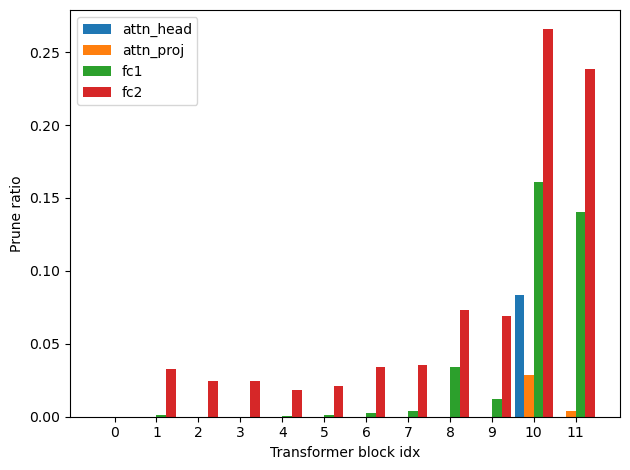

In [13]:
n_layers = ratios.shape[0]          
bar_width = 0.23                        
x = np.arange(n_layers)                

labels = ["attn_head", "attn_proj", "fc1", "fc2", ]

# Center the 4 bars around each x position
offsets = (np.arange(ratios.shape[1]) - (ratios.shape[1] - 1) / 2) * bar_width

for j, offset in enumerate(offsets):
    plt.bar(x + offset, ratios[:, j], width=bar_width, label=labels[j])

plt.xlabel("Transformer block idx")
plt.ylabel("Prune ratio")
title = "attn_head: " + str(avg_attn) +" attn_proj: " + str(avg_proj)
plt.title("")
plt.xticks(x, [str(i) for i in range(n_layers)])
plt.legend()
plt.tight_layout()
plt.show()